In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K


In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
latent_dim=2

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [40]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [6]:
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
_, img_height, img_width = x_train.shape
input_shape = (img_height, img_width, 1)

In [9]:
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, 1)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, 1)

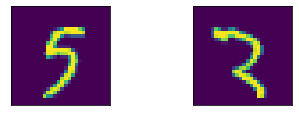

In [10]:
axis = plt.subplot(2,2,1)
plt.imshow(x_train[420].reshape(28,28,1))  
axis.get_xaxis().set_visible(False)
axis.get_yaxis().set_visible(False)

axis = plt.subplot(2,2,2)
plt.imshow(x_train[500].reshape(28,28,1))  
axis.get_xaxis().set_visible(False)
axis.get_yaxis().set_visible(False)

In [11]:
latent_dim = 2

In [12]:
input_img = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(input_img)
x = layers.Conv2D(64, 3, strides=(2,2), padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
conv_shape = K.int_shape(x)

x= layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)

z_mu = layers.Dense(latent_dim)(x)
z_sigma = layers.Dense(latent_dim)(x)

In [13]:
conv_shape

(None, 14, 14, 64)

In [14]:
z_mu

<tf.Tensor 'dense_1/BiasAdd:0' shape=(None, 2) dtype=float32>

In [15]:
tf.shape(z_mu)

<tf.Tensor 'Shape:0' shape=(2,) dtype=int32>

In [16]:
K.int_shape(z_mu)[1]

2

In [17]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(tf.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma/2) * eps

In [18]:
z = layers.Lambda(sample_z, output_shape=(latent_dim, ))((z_mu, z_sigma))

In [19]:
encoder = Model(input_img, [z_mu, z_sigma, z], name="encoder")

In [20]:
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [21]:
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation="relu")(decoder_input)
x = tf.reshape(x, (-1, conv_shape[1], conv_shape[2],conv_shape[3]))
x= layers.Conv2DTranspose(32, 3, strides=(2,2), padding="same", activation="relu")(x)
x= layers.Conv2DTranspose(1, 3, padding="same", activation="relu")(x)
decoder = Model(decoder_input, x)

In [22]:
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             37632     
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 14, 14, 64)]      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [23]:
z_decoded = decoder(z)

In [24]:
class CustomLayer(layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = layers.Flatten()(x)
    z_decoded =  layers.Flatten()(z_decoded)
    recon_loss = tf.keras.metrics.binary_crossentropy(x,z_decoded)
    kl_loss = -5e-4 * tf.reduce_mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma),  
                             axis=-1)
    return tf.reduce_mean(recon_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

In [25]:
y = CustomLayer()([input_img, z_decoded])

In [26]:
vae = Model(input_img, y)

In [27]:
vae.compile(optimizer="adam", loss=None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [30]:
vae.fit(x_train, 
        None, 
        epochs=10, 
        batch_size=32,
        validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47840/48000 [============================>.] - ETA: 0s - loss: 0.2183

C:\Users\user\anaconda3\envs\tensorflow-2.4-cuda11\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 11s 231us/sample - loss: 0.2183 - val_loss: 0.2134
Epoch 2/10
48000/48000 [==============================] - 11s 229us/sample - loss: 0.2114 - val_loss: 0.2077
Epoch 3/10
48000/48000 [==============================] - 11s 230us/sample - loss: 0.2096 - val_loss: 0.2068
Epoch 4/10
48000/48000 [==============================] - 11s 228us/sample - loss: 0.2055 - val_loss: 0.2011
Epoch 5/10
48000/48000 [==============================] - 11s 234us/sample - loss: 0.2030 - val_loss: 0.2059
Epoch 6/10
48000/48000 [==============================] - 11s 232us/sample - loss: 0.1995 - val_loss: 0.1963
Epoch 7/10
48000/48000 [==============================] - 11s 222us/sample - loss: 0.1997 - val_loss: 0.1958
Epoch 8/10
48000/48000 [==============================] - 11s 228us/sample - loss: 0.1978 - val_loss: 0.2070
Epoch 9/10
48000/48000 [==============================] - 11s 223us/sample - loss: 0.2007 - val_loss: 0.1961
Epoch 10/10
48000/48000 [=====

In [31]:
mu, _, _, = encoder.predict(x_test)

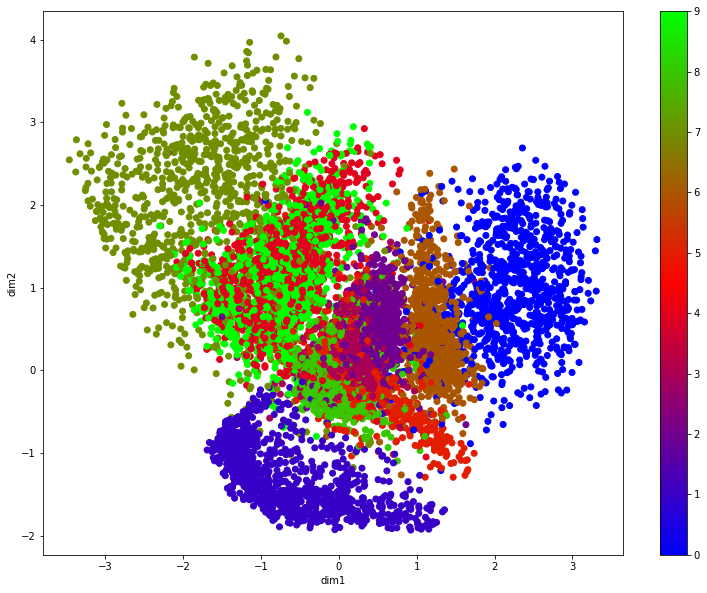

In [39]:
plt.figure(figsize=(13, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap="brg")
plt.xlabel("dim1")
plt.ylabel("dim2")
plt.colorbar()
plt.show()

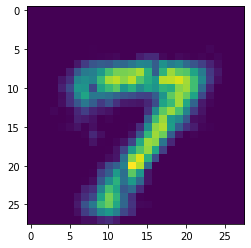

In [43]:
sample_vector = np.array([[-3,2.5]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshape = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshape)